In [1]:
import optuna
from pysr import PySRRegressor
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

e:\Documents\Coding\Repositorios\MyRepositories\NewMortalityCurves\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [ ]:
# 1. Prepare toy data
X = np.random.randn(200, 5)
y = 2.5 * np.cos(X[:, 2]) + X[:, 0]**2 - 0.3 * X[:, 1]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2. Define Optuna objective
def objective(trial: optuna.Trial) -> float:
    # Suggest PySR hyperparameters
    pop_size = trial.suggest_int("population_size", 50, 500)
    n_iters = trial.suggest_int("niterations", 10, 100)
    parsimony = trial.suggest_float("parsimony", 0.001, 0.1, log=True)
    optimizer_restarts = trial.suggest_int("optimizer_nrestarts", 1, 10)

    model = PySRRegressor(
        population_size=pop_size,
        niterations=n_iters,
        parsimony=parsimony,
        optimizer_nrestarts=optimizer_restarts,
        # you can add more PySR settings here...
    )

    # Fit and evaluate
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    return mean_squared_error(y_valid, y_pred)

# 3. Create and run the study
sampler = optuna.samplers.TPESampler()  # default TPE sampler :contentReference[oaicite:2]{index=2}
pruner = optuna.pruners.MedianPruner()  # stop unpromising trials early :contentReference[oaicite:3]{index=3}

study = optuna.create_study(
    storage = "sqlite:///db.sqlite3",
    study_name = "pysr-test_study",
    direction="minimize",
    sampler=sampler,
    pruner=pruner
)
study.optimize(objective, n_trials=50, timeout=600)

print("Best MSE:", study.best_value)
print("Best params:", study.best_params)

In [3]:
study.best_params

{'population_size': 407,
 'niterations': 77,
 'parsimony': 0.08919810761494844,
 'optimizer_nrestarts': 6}

# Multiple Optimization - Pareto Front

In [2]:
import numpy as np

# Set a random seed for reproducibility
np.random.seed(42)

# Create 5 datasets
Xs = []
Ys = []

n_samples = 100  # Number of points per dataset

# Dataset 1: Linear
X1 = np.random.uniform(-5, 5, size=(n_samples, 1))
y1 = 2 * X1[:, 0] + 1 + np.random.normal(0, 0.5, size=n_samples)

# Dataset 2: Quadratic
X2 = np.random.uniform(-3, 3, size=(n_samples, 1))
y2 = 0.5 * X2[:, 0]**2 - 3 * X2[:, 0] + 2 + np.random.normal(0, 0.5, size=n_samples)

# Dataset 3: Sinusoidal
X3 = np.random.uniform(0, 2*np.pi, size=(n_samples, 1))
y3 = np.sin(X3[:, 0]) + 0.1 * np.random.normal(0, 1, size=n_samples)

# Dataset 4: Exponential decay
X4 = np.random.uniform(0, 5, size=(n_samples, 1))
y4 = np.exp(-X4[:, 0]) + np.random.normal(0, 0.05, size=n_samples)

# Dataset 5: Cubic
X5 = np.random.uniform(-2, 2, size=(n_samples, 1))
y5 = X5[:, 0]**3 - X5[:, 0]**2 + X5[:, 0] + np.random.normal(0, 0.2, size=n_samples)

# Store them in lists
Xs = [X1, X2, X3, X4, X5]
Ys = [y1, y2, y3, y4, y5]


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
import optuna
from optuna.samplers import NSGAIIISampler
from pysr import PySRRegressor
import sympy as smp

# Assume you have 5 datasets in lists Xs and Ys
Xs = [X1, X2, X3, X4, X5]
Ys = [y1, y2, y3, y4, y5]


def objective(trial):
    binary_operators_comb = [
        ["+", "-"],
        ["+", "-", "*"],
        ["+", "-", "/"],
        ["+", "-", "*", "/"]
    ]

    unary_operators_comb = [
        ["exp"],
        ["exp", "exp_neg(x) = exp(-x)"],
        ["exp", "square"],
        ["exp", "square", "cube"],
        ["exp", "sqrt"],
        ["exp", "inv"],
        ["exp", "abs"]
    ]

    denoise_comb = ["False", "True"]

    # Suggest shared hyperparameters
    pop_size = trial.suggest_int("population_size", 20, 200)
    populations = trial.suggest_int("populations", 20, 300)
    n_iters = trial.suggest_int("niterations", 10, 500)
    parsimony = trial.suggest_float("parsimony", 1e-4, 1e-1, log=True)
    adaptive_parsimony_scaling = trial.suggest_float("adaptive_parsimony_scaling", 1000, 2000)
    binary_operators = trial.suggest_categorical("binary_operators", binary_operators_comb)
    unary_operators = trial.suggest_categorical("unary_operators", unary_operators_comb)
    maxsize = trial.suggest_int("maxsize", 10, 70)
    denoise = trial.suggest_categorical("denoise", denoise_comb)


    # Instantiate PySR with these hyperparameters
    model = PySRRegressor(
        random_state=42,
        # deterministic=True,
        # parallelism="serial",
        verbosity=0,
        progress=False,
        temp_equation_file=True,
        delete_tempfiles=True,
        population_size=pop_size,
        niterations=n_iters,
        parsimony=parsimony,
        binary_operators=binary_operators,
        unary_operators=unary_operators,
        denoise=denoise,
        populations=populations,
        adaptive_parsimony_scaling=adaptive_parsimony_scaling,
        maxsize=maxsize,
        extra_sympy_mappings={
            "exp_neg": lambda x: smp.exp(-x)
        },
        timeout_in_seconds=1200
    )

    # Compute MSE on each dataset
    losses = []
    for X, y in zip(Xs, Ys):
        model.fit(X, y)
        losses.append(mean_squared_error(y, model.predict(X)))

    # Return a tuple of five objectives (one per dataset)
    return tuple(losses)

# Create a multi-objective study for 5 minimization tasks
study = optuna.create_study(
    storage = "sqlite:///db.sqlite4",
    study_name = "pysr_Pareto_III_full_params3-test_study",
    directions=["minimize"] * 5,
    sampler=NSGAIIISampler()
)

# Run 100 trials of the genetic algorithm
study.optimize(objective, timeout=1200)

# Retrieve the Pareto front trials
pareto_trials = study.best_trials
print("Number of Pareto-optimal trials:", len(pareto_trials))


C:\Users\guilherme\AppData\Local\Temp\ipykernel_4644\530810409.py:83: ExperimentalWarning: NSGAIIISampler is experimental (supported from v3.2.0). The interface can change in the future.
  sampler=NSGAIIISampler()
[I 2025-04-27 19:51:35,000] A new study created in RDB with name: pysr_Pareto_III_full_params3-test_study
e:\Documents\Coding\Repositorios\MyRepositories\NewMortalityCurves\.venv\Lib\site-packages\pysr\sr.py:1848: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(
e:\Documents\Coding\Repositorios\MyRepositories\NewMortalityCurves\.venv\Lib\site-packages\pysr\sr.py:2191: UserWarning: The discovered expressions are being reset. Please set `warm_start=True` if you wish to continue to start a search where you left off.
  warnings.warn(
e:\Documents\Coding\Repositorios\MyRepositories\NewMortalityCurves\.venv\Lib\site-packages\pysr\sr.py:1848: UserWarning: Note: S

Number of Pareto-optimal trials: 3


In [11]:
study.best_trials[1].params

{'population_size': 55,
 'populations': 49,
 'niterations': 456,
 'parsimony': 0.0019208984574494764,
 'adaptive_parsimony_scaling': 1801.3006739681143,
 'binary_operators': ['+', '-', '*', '/'],
 'unary_operators': ['exp', 'sqrt'],
 'maxsize': 15,
 'denoise': 'False'}

In [13]:
import pickle

with open("test_pareto_study_III.pkl", "rb") as file:
    # pickle.dump(study, file)
    study = pickle.load(file)
    

In [14]:
study.best_trials

[FrozenTrial(number=0, state=1, values=[0.20164614180977355, 0.198699930160252, 0.010874067896239903, 0.002900096577527691, 0.034309282287740606], datetime_start=datetime.datetime(2025, 4, 27, 16, 45, 14, 325475), datetime_complete=datetime.datetime(2025, 4, 27, 16, 52, 28, 830727), params={'population_size': 314, 'niterations': 54, 'parsimony': 0.002595596720701991}, user_attrs={}, system_attrs={'nsga3:generation': 0}, intermediate_values={}, distributions={'population_size': IntDistribution(high=500, log=False, low=50, step=1), 'niterations': IntDistribution(high=100, log=False, low=10, step=1), 'parsimony': FloatDistribution(high=0.1, log=True, low=0.0001, step=None)}, trial_id=11, value=None),
 FrozenTrial(number=1, state=1, values=[0.20164614100529488, 0.198699930159693, 0.010874073796885278, 0.0029000965712195443, 0.03430928231042018], datetime_start=datetime.datetime(2025, 4, 27, 16, 52, 29, 285464), datetime_complete=datetime.datetime(2025, 4, 27, 16, 59, 33, 774147), params={'

In [7]:
optuna.visualization.plot_pareto_front(study, 
    targets=lambda t: (t.values[0], t.values[1]),
    target_names=["Objective 0", "Objective 1"]
)

In [9]:
import numpy as np
from pymoo.indicators.hv import Hypervolume
from kneed import KneeLocator

# Suppose `pareto_vals` is your (n_points × 5) NumPy array of objective values
pareto_vals = np.array([t.values for t in study.best_trials])  # shape (n_points, 5)

# 1. Normalize objectives to [0,1]
ideal = pareto_vals.min(axis=0)
nadir = pareto_vals.max(axis=0)
norm = (pareto_vals - ideal) / (nadir - ideal + 1e-12)

# 2. Hypervolume contribution
ref_point = np.ones(5)  # reference outside normalized front
hv_func = Hypervolume(ref_point=ref_point)
hv_all = hv_func(norm)
# compute contribution for each point
contr = np.zeros(norm.shape[0])
for i in range(norm.shape[0]):
    mask = np.arange(norm.shape[0]) != i
    contr[i] = hv_all - hv_func(norm[mask])
best_hv_idx = np.argmax(contr)

# 3. Knee detection on sorted Manhattan distances
manh = np.sum(norm, axis=1)
sorted_idx = np.argsort(manh)
sorted_manh = manh[sorted_idx]
kl = KneeLocator(
    x=list(range(len(sorted_manh))),
    y=sorted_manh.tolist(),
    curve="concave",
    direction="increasing"
)
knee_rank = kl.knee  # index in sorted list
best_knee_idx = sorted_idx[knee_rank]


# 5. Aggregate or compare
print("Best by hypervolume contribution:", best_hv_idx)
print("Best by knee detection:", best_knee_idx)


Best by hypervolume contribution: 1
Best by knee detection: [[1 0 2]]


In [8]:
pareto_vals[2]

array([0.20164644, 0.19869993, 0.00941338, 0.0029001 , 0.03430928])

# Actual Mortality Data

In [139]:
countries = ["USA", "Australia", "Japan", "France", "Russia", "Chile"]

In [143]:
full_data = []
for country in countries:
    true_data = pd.read_csv(f"../RealData/data/{country}-Mx_1x1.txt", sep=r'\s+')
    true_data["Age"] = true_data["Age"].map(lambda x: 110 if x == "110+" else x)
    true_data.Age = true_data.Age.astype("int")

    columns_to_clean = ["Total", "Male", "Female"]
    for column in columns_to_clean:
        true_data[column] = true_data.Total.replace(".", np.nan)
        true_data[column] = true_data.Total.replace("0.000000", np.nan)
        true_data = true_data.dropna()
        true_data[column] = true_data[column].astype("float")

    true_data["Country"] = country
    full_data.append(true_data)

countries_data = pd.concat(full_data)
countries_data

,Year,Age,Female,Male,Total,Country
0,1933,0,0.061292,0.061292,0.061292,USA
1,1933,1,0.009459,0.009459,0.009459,USA
2,1933,2,0.004351,0.004351,0.004351,USA
3,1933,3,0.003104,0.003104,0.003104,USA
4,1933,4,0.002386,0.002386,0.002386,USA
...,...,...,...,...,...,...
3214,2020,106,0.677201,0.677201,0.677201,Chile
3215,2020,107,0.482412,0.482412,0.482412,Chile
3216,2020,108,0.395691,0.395691,0.395691,Chile
3217,2020,109,0.578685,0.578685,0.578685,Chile


In [146]:
"""
- Australia: 2021
- Russia: 2014
- Japan: 1988
- Chile: 2019
- France: 1990
- USA: 1960
"""

HPO_countries = {
    "Australia": 2021,
    "Russia": 2014,
    "Japan": 1988,
    "Chile": 2019,
    "France": 1990,
    "USA": 1960
}

Xs, Ys = [], []
for country, year in HPO_countries.items():
    data_ = countries_data[(countries_data.Country == country) & (countries_data.Year == year)]
    Xs.append(data_.Age.values)
    Ys.append(data_.Total.values)

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
import optuna
from optuna.samplers import NSGAIIISampler
from pysr import PySRRegressor
import sympy as smp

def objective(trial):
    binary_operators_comb = [
        ["+", "-"],
        ["+", "-", "*"],
        ["+", "-", "/"],
        ["+", "-", "*", "/"]
    ]

    unary_operators_comb = [
        ["exp"],
        ["exp", "exp_neg(x) = exp(-x)"],
        ["exp", "square"],
        ["exp", "square", "cube"],
        ["exp", "sqrt"],
        ["exp", "inv"],
        ["exp", "abs"]
    ]

    denoise_comb = ["False", "True"]

    # Suggest shared hyperparameters
    pop_size = trial.suggest_int("population_size", 20, 200)
    populations = trial.suggest_int("populations", 20, 300)
    n_iters = trial.suggest_int("niterations", 10, 500)
    parsimony = trial.suggest_float("parsimony", 1e-4, 1e-1, log=True)
    adaptive_parsimony_scaling = trial.suggest_float("adaptive_parsimony_scaling", 1000, 2000)
    binary_operators = trial.suggest_categorical("binary_operators", binary_operators_comb)
    unary_operators = trial.suggest_categorical("unary_operators", unary_operators_comb)
    maxsize = trial.suggest_int("maxsize", 10, 70)
    denoise = trial.suggest_categorical("denoise", denoise_comb)


    # Instantiate PySR with these hyperparameters
    model = PySRRegressor(
        random_state=42,
        # deterministic=True,
        # parallelism="serial",
        verbosity=0,
        progress=False,
        temp_equation_file=True,
        delete_tempfiles=True,
        population_size=pop_size,
        niterations=n_iters,
        parsimony=parsimony,
        binary_operators=binary_operators,
        unary_operators=unary_operators,
        denoise=denoise,
        populations=populations,
        adaptive_parsimony_scaling=adaptive_parsimony_scaling,
        maxsize=maxsize,
        extra_sympy_mappings={
            "exp_neg": lambda x: smp.exp(-x)
        },
        timeout_in_seconds=1200
    )

    # Compute MSE on each dataset
    losses = []
    for X, y in zip(Xs, Ys):
        model.fit(X, y)
        losses.append(mean_squared_error(y, model.predict(X)))

    # Return a tuple of five objectives (one per dataset)
    return tuple(losses)

# Create a multi-objective study for 5 minimization tasks
study = optuna.create_study(
    storage = "sqlite:///db.sqlite4",
    study_name = "pysr_Pareto_III_full_params3-test_study",
    directions=["minimize"] * 5,
    sampler=NSGAIIISampler()
)

# Run 100 trials of the genetic algorithm
study.optimize(objective, timeout=1200)

# Retrieve the Pareto front trials
pareto_trials = study.best_trials
print("Number of Pareto-optimal trials:", len(pareto_trials))


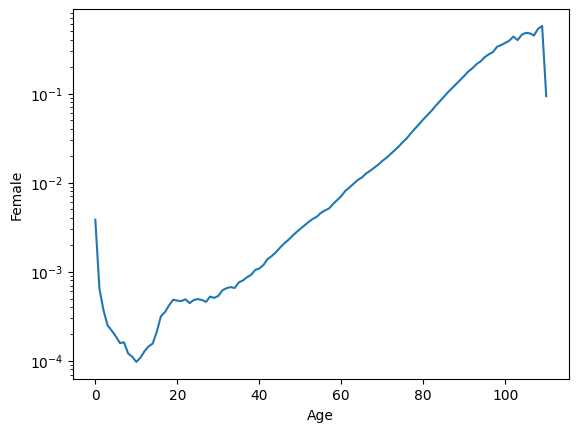

In [128]:
data_ = true_data[true_data.Year == 1996]

sns.lineplot(data=data_, x="Age", y="Female")
plt.yscale("log")
plt.show()

- Australia: 2021
- Russia: 2014
- Japan: 1988
- Chile: 2019
- France: 1990
- USA: 1960

In [ ]:
import pandas as pd
from dash import Dash, dcc, html, Input, Output
import plotly.express as px

df = countries_data
df.columns = ["year", "age", "female", "male", "total", "country"]

app = Dash(__name__)

app.layout = html.Div([
    html.H1("Mortality: Age vs Total"),
    dcc.Dropdown(
        id="country-dropdown",
        options=[{"label": c, "value": c} for c in sorted(df["country"].unique())],
        value=sorted(df["country"].unique())[0]
    ),
    dcc.Dropdown(
        id="year-dropdown",
        options=[{"label": y, "value": y} for y in sorted(df["year"].unique())],
        value=sorted(df["year"].unique())[0]
    ),
    dcc.Graph(id="age-total-line")
])

@app.callback(
    Output("age-total-line", "figure"),
    Input("country-dropdown", "value"),
    Input("year-dropdown", "value")
)
def update_line(country, year):
    # Filter DataFrame
    dff = df[(df["country"] == country) & (df["year"] == year)]
    dff.total = np.log(dff.total)
    # Create line plot with Plotly Express
    fig = px.line(dff, x="age", y="total",
                  title=f"{country} — Age vs Total ({year})")  # px.line docs :contentReference[oaicite:5]{index=5}
    fig.update_layout(xaxis_title="Age", yaxis_title="Total")
    return fig

if __name__ == "__main__":
    app.run(debug=True)
